# An interesting approach, although arguably impractical due to the high False Positives (with oversampling).

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample

Epoch 1/7, Loss: 0.1284
Epoch 2/7, Loss: 0.0001
Epoch 3/7, Loss: 0.0075
Epoch 4/7, Loss: 0.0001
Epoch 5/7, Loss: 0.0090
Epoch 6/7, Loss: 0.0007
Epoch 7/7, Loss: 0.0027
Test Accuracy: 0.9992
Precision: 0.9983
Recall (TPR): 1.0000
TNR: 0.9983
F1 Score: 0.9992
ROC AUC: 0.9998


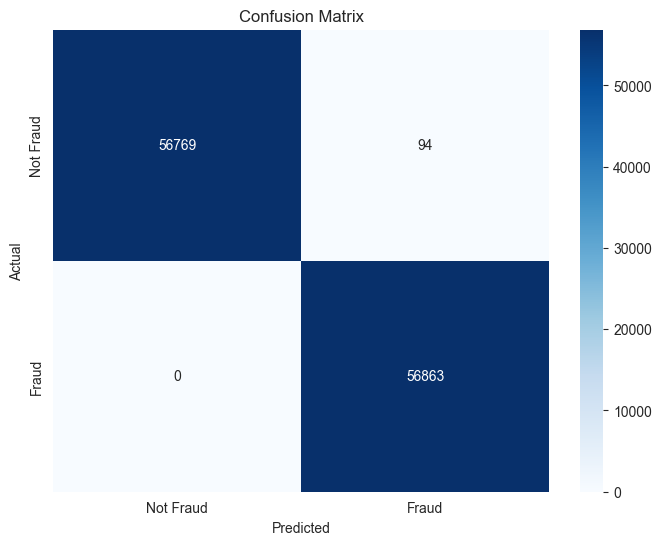

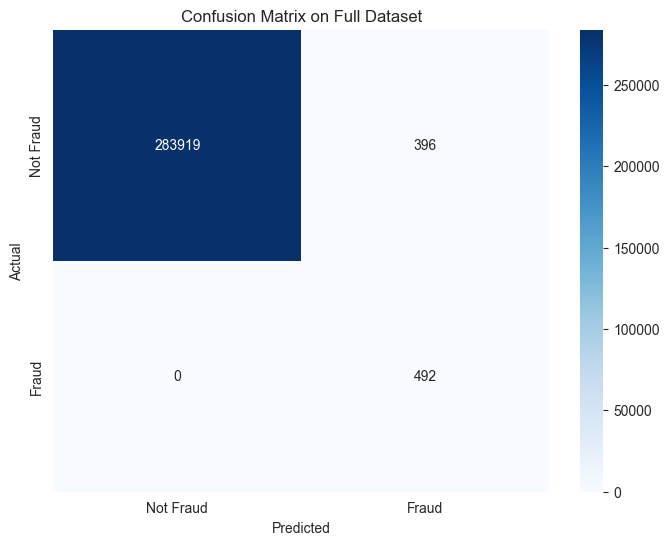

In [3]:


file_path = 'creditcard_2013.csv'
data = pd.read_csv(file_path)

X = data.drop('Class', axis=1)
y = data['Class']

tot_seconds = X['Time']
X['sin_tot_seconds'] = np.sin(2 * np.pi * tot_seconds / (24 * 60 * 60))
X['cos_tot_seconds'] = np.cos(2 * np.pi * tot_seconds / (24 * 60 * 60))
X = X.drop('Time', axis=1)

amount_pt = PowerTransformer(method='box-cox')
X['Amount'] = amount_pt.fit_transform(X[['Amount']] + 1e-9)

X['Extra'] = 0
# X['Extra1'] = 0

data = pd.concat([X, y], axis=1)


# multiplier = 100000000
# # Outlier Detection and Removal using IQR method
# def remove_outliers(df, column, multiplier):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - multiplier * IQR
#     upper_bound = Q3 + multiplier * IQR
#     return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]




minority_class = data[data['Class'] == 1]
majority_class = data[data['Class'] == 0]

minority_oversampled = resample(minority_class,
                                replace=True,  # Sample with replacement
                                n_samples=len(majority_class),  # Match number in majority class
                                random_state=422)  # Reproducible results

# Combine majority class with oversampled minority class
balanced_data = pd.concat([majority_class, minority_oversampled])

# Shuffle the balanced dataset
balanced_data = balanced_data.sample(frac=1, random_state=422).reset_index(drop=True)



# Outlier detection and removal after balancing
features_to_check = [col for col in balanced_data.columns if col not in ['Class']]

# Remove outliers from each feature in the balanced data
# for feature in features_to_check:
#     balanced_data = remove_outliers(balanced_data, feature, multiplier)




X_balanced = balanced_data.drop('Class', axis=1)
y_balanced = balanced_data['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_balanced, test_size=0.2, random_state=412, stratify=y_balanced)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads, num_classes):
        super(TransformerModel, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads, batch_first=True)
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = x + attn_output
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()

model = TransformerModel(input_dim=X_train.shape[1], num_heads=8, num_classes=1)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 7
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

model.eval()
all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.unsqueeze(1)
        outputs = model(X_batch)
        probs = outputs
        predicted = (outputs > 0.5).float()
        all_preds.extend(predicted.tolist())
        all_labels.extend(y_batch.tolist())
        all_probs.extend(probs.tolist())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)

cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()
tnr = tn / (tn + fp)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall (TPR): {recall:.4f}')
print(f'TNR: {tnr:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

data_fresh = pd.read_csv(file_path)

X_fresh = data_fresh.drop('Class', axis=1)
y_fresh = data_fresh['Class']

tot_seconds_fresh = X_fresh['Time']
X_fresh['sin_tot_seconds'] = np.sin(2 * np.pi * tot_seconds_fresh / (24 * 60 * 60))
X_fresh['cos_tot_seconds'] = np.cos(2 * np.pi * tot_seconds_fresh / (24 * 60 * 60))
X_fresh = X_fresh.drop('Time', axis=1)

amount_pt_fresh = PowerTransformer(method='box-cox')
X_fresh['Amount'] = amount_pt_fresh.fit_transform(X_fresh[['Amount']] + 1e-9)

X_fresh['Extra'] = 0
# X_fresh['Extra1'] = 0

X_fresh_scaled = scaler.transform(X_fresh)

X_fresh_tensor = torch.tensor(X_fresh_scaled, dtype=torch.float32)
y_fresh_tensor = torch.tensor(y_fresh.values, dtype=torch.float32)

# Use the entire dataset for prediction
model.eval()
all_preds_fresh = []
all_labels_fresh = []
all_probs_fresh = []
with torch.no_grad():
    outputs = model(X_fresh_tensor.unsqueeze(1))
    probs = outputs
    predicted = (outputs > 0.5).float()
    all_preds_fresh.extend(predicted.tolist())
    all_labels_fresh.extend(y_fresh_tensor.tolist())
    all_probs_fresh.extend(probs.tolist())


cm_fresh = confusion_matrix(all_labels_fresh, all_preds_fresh)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_fresh, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Full Dataset')
plt.show()
